<h4> Description</h4>
<p>In this project we are tasked to build a machine learning model that predicts which tweets are about real disasters ans which one are not.
Twitter(X) has become an important channel for communication in time of emergency. A lot of people post text data realated to the disaster happened around them. We humans can easily distinguish what kind of texts indicate real disaster. But for machine simple task are really hard.
</p>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, SimpleRNN, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

train_df.head(), train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


(   id keyword location                                               text  \
 0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
 1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
 2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
 3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
 4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   
 
    target  
 0       1  
 1       1  
 2       1  
 3       1  
 4       1  ,
 None)

In [3]:
# Distribution of target

print((train_df.target == 1).sum())
print((train_df.target ==0).sum())

3271
4342


There are lot of data points are missing. Do preprocessing to remove URL, punctuations, and stopwords

In [4]:
import re 
import string
# remove URL from the text

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)
# remove puncuations

def punc_remove(text):
     translator = str.maketrans('', '', string.punctuation) # Create a translation table to delete all punctuation
     return text.translate(translator) 



In [5]:
pattern = re.compile(r'https?://(\S+|www)\.\S+')
for t in train_df.text:
    matches = pattern.findall(t)
    for match in matches:
        print(t)
        print(match)
        print(pattern.sub(r'', t))
    if len(matches) > 0:
        break

@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C
t
@bbcmtd Wholesale Markets ablaze 


In [6]:
# Apply the functions
train_df['text'] = train_df.text.map(remove_URL) # map(lambda x : remove_URL(x))
train_df['text'] = train_df.text.map(punc_remove)

In [7]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1
2,5,NaN,NaN,All residents asked to shelter in place are be...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1


In [8]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = set(stopwords.words('english'))

def remove_stopwords(text):
    filtered_words = [word for word in text.split() if word not in stopwords.words('english')]
    return ' '.join(filtered_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ashok\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
text_length = train_df['text'].str.len()
text_length.describe()

count    7613.000000
mean       83.591226
std        31.460470
min         6.000000
25%        60.000000
50%        85.000000
75%       109.000000
max       145.000000
Name: text, dtype: float64

In [10]:
train_df['text'] = train_df['text'].map(remove_stopwords)
train_df.text

0        Our Deeds Reason earthquake May ALLAH Forgive us
1                   Forest fire near La Ronge Sask Canada
2       All residents asked shelter place notified off...
3       13000 people receive wildfires evacuation orde...
4       Just got sent photo Ruby Alaska smoke wildfire...
                              ...                        
7608    Two giant cranes holding bridge collapse nearb...
7609    ariaahrary TheTawniest The control wild fires ...
7610                    M194 0104 UTC5km S Volcano Hawaii
7611    Police investigating ebike collided car Little...
7612    The Latest More Homes Razed Northern Californi...
Name: text, Length: 7613, dtype: object

In [11]:
# count the unique words

from collections import Counter

def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count

In [12]:
# the number of unique words

counter = counter_word(train_df.text)
num_unique_words = len(counter)
num_unique_words

22093

In [13]:
counter.most_common(5)

[('I', 1225), ('The', 581), ('like', 321), ('A', 302), ('amp', 298)]

Second step in preprocessing use tokenization of the text data

In [14]:
# split the data

from sklearn.model_selection import train_test_split

X = train_df.text
y = train_df.target

X_train, X_val, y_train, y_val  = train_test_split(X, y, test_size = 0.2, random_state=0)

In [15]:
X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_test = np.array(y_val)

In [18]:
# Tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
import random
# Vectorize a text corpus by turning each text into a sequence of integers
tokenizer = Tokenizer(num_words = num_unique_words)
tokenizer.fit_on_texts(X_train)

In [19]:
word_index = tokenizer.word_index

# 5 samples of word_index
random_keys = random.sample(list(word_index.keys()), 5)
for key in random_keys:
  print(f"key: {key}, value: {word_index[key]}")

key: mouth, value: 4677
key: wwi, value: 3162
key: bernardino, value: 4209
key: worker, value: 3823
key: 10km, value: 11180


In [20]:
# Convert text data to sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
val_sequences = tokenizer.texts_to_sequences(X_val)

# An example
print(X_train[1:3])
print(train_sequences[1:3])

['This first year Forest Service spent half annual budget fighting fires climatechange'
 'lightseraphs pissed could pikachu electrocute']
[[28, 36, 120, 116, 310, 1747, 419, 1748, 1553, 1180, 44, 3810], [5760, 3811, 84, 5761, 533]]


In [21]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Max number of words in a sequence
max_length = 20

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post", truncating="post")
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding="post", truncating="post")

In [22]:
print(X_train[10])
print(train_sequences[10])
print(train_padded[10])

WeaponXmusic hey guys thanks rock world follow
[5771, 627, 536, 447, 1182, 49, 842]
[5771  627  536  447 1182   49  842    0    0    0    0    0    0    0
    0    0    0    0    0    0]


In [23]:
# flip (key, value)
reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])

In [24]:
def decode(sequence):
    return " ".join([reverse_word_index.get(idx, "?") for idx in sequence])

decoded_text = decode(train_sequences[10])

print(train_sequences[10])
print(decoded_text)

[5771, 627, 536, 447, 1182, 49, 842]
weaponxmusic hey guys thanks rock world follow


<h3> RNN model; Bidirectional and Stacked LSTM</h3>
<p>
A Bidirectional LSTM is an enhanced version of the standard LSTM that processes input sequences in both forward and backward directions. This allows the model to leverage context from both preceding and succeeding tokens for each token in the sequence. Such a mechanism is particularly useful in tasks like sentence classification, where the meaning of a word often relies on the words surrounding it.

A Stacked LSTM, on the other hand, involves layering multiple LSTM units on top of one another to form a deeper network. This configuration enables the model to capture hierarchical patterns in the input data, with each layer extracting progressively more abstract and complex features of the sequence.

We can design a model that integrates both BiLSTM and Stacked LSTM techniques to explore their combined effectiveness and evaluate its accuracy.</p>

In [25]:
from tensorflow.keras.layers import Bidirectional, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential

# Define the model
model_bi = Sequential([
    Embedding(input_dim=num_unique_words, output_dim=32, input_length=max_length),
    Bidirectional(LSTM(256, return_sequences=True, dropout=0.1)),
    Bidirectional(LSTM(256, return_sequences=True, dropout=0.1)),
    LSTM(256),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation="sigmoid")
])

model_bi.summary()

# Compile and train
model_bi.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_bi = model_bi.fit(
    train_padded, y_train, 
    epochs=10, batch_size=64, 
    validation_data=(val_padded, y_val), 
    callbacks=[early_stopping]
)

C:\Users\ashok\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 56s 433ms/step - accuracy: 0.5485 - loss: 0.6868 - val_accuracy: 0.5857 - val_loss: 0.6712
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 38s 393ms/step - accuracy: 0.6572 - loss: 0.6100 - val_accuracy: 0.7702 - val_loss: 0.5000
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 36s 379ms/step - accuracy: 0.8337 - loss: 0.3946 - val_accuracy: 0.7971 - val_loss: 0.4741
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 435ms/step - accuracy: 0.8823 - loss: 0.2969 - val_accuracy: 0.7938 - val_loss: 0.4995
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 428ms/step - accuracy: 0.9079 - loss: 0.2397 - val_accuracy: 0.7912 - val_loss: 0.5579
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 39s 405ms/step - accuracy: 0.9399 - loss: 0.1701 - val_accuracy: 0.7833 - val_loss: 0.6072


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.7973 - loss: 0.4685
Loss: 0.47410061955451965, Accuracy: 0.7971109747886658


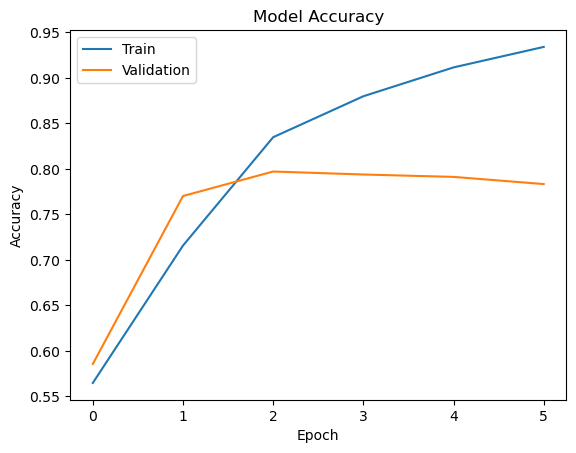

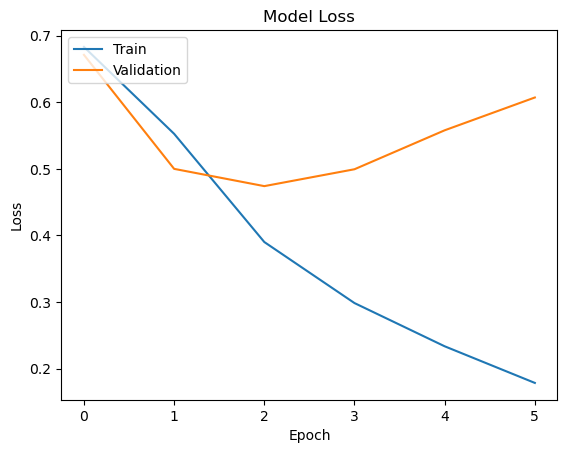

In [26]:
# Evaluate the model
loss_bi, accuracy_bi = model_bi.evaluate(val_padded, y_val)
print(f"Loss: {loss_bi}, Accuracy: {accuracy_bi}")

# Plot accuracy and loss
for metric, title in zip(['accuracy', 'loss'], ['Model Accuracy', 'Model Loss']):
    plt.plot(history_bi.history[metric], label='Train')
    plt.plot(history_bi.history[f'val_{metric}'], label='Validation')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend(loc='upper left')
    plt.show()
plt.show()

CNNs can be utilized for Natural Language Processing tasks and, in some scenarios, serve as an effective alternative to RNNs. While RNNs are typically preferred for tasks that rely on sequential information, such as language modeling or translation, CNNs can also be adapted to extract critical features from text sequences.

Unlike RNNs, which maintain a sequential memory, CNNs lack an inherent mechanism to preserve context across steps. However, their ability to efficiently process input and capture local patterns makes them particularly effective for tasks like text classification.

In [27]:

# Define CNN model
model_cnn = Sequential([
    Embedding(input_dim=num_unique_words, output_dim=128, input_length=max_length),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2),
    Conv1D(32, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(10, activation='relu'),
    Dropout(0.35),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_cnn.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history_cnn = model_cnn.fit(train_padded, y_train, epochs=20, batch_size=32, validation_data=(val_padded, y_val), callbacks=[early_stopping])

# Evaluate the model
loss_cnn, accuracy_cnn = model_cnn.evaluate(val_padded, y_val)
print('Loss:', loss_cnn)
print('Accuracy:', accuracy_cnn)

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.5464 - loss: 0.6890 - val_accuracy: 0.5942 - val_loss: 0.6752
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.6144 - loss: 0.6694 - val_accuracy: 0.6953 - val_loss: 0.6543
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.7395 - loss: 0.6215 - val_accuracy: 0.7420 - val_loss: 0.5874
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8180 - loss: 0.5120 - val_accuracy: 0.7846 - val_loss: 0.4945
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.8773 - loss: 0.3613 - val_accuracy: 0.7945 - val_loss: 0.4664
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9165 - loss: 0.2731 - val_accuracy: 0.7945 - val_loss: 0.4773
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9459 - loss: 0.1964 - val_accuracy: 0.7866 - val_loss: 0.5050
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9561 - loss: 0.1584 - val_ac

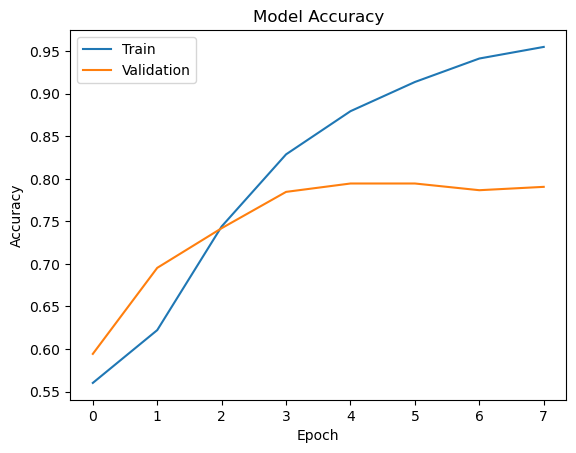

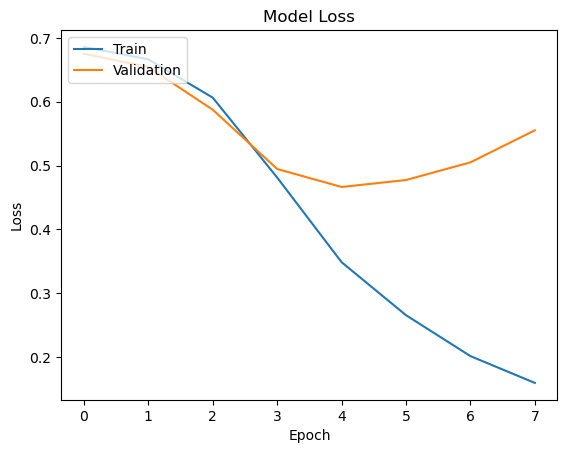

In [29]:
# Plot accuracy and loss
for metric in ['accuracy', 'loss']:
    plt.plot(history_cnn.history[metric], label='Train')
    plt.plot(history_cnn.history[f'val_{metric}'], label='Validation')
    plt.title(f'Model {metric.capitalize()}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend(loc='upper left')
    plt.show()

<h2>Improving the model with pre-trained GloVe embeddings</h2>
GloVe (Global Vectors for Word Representation) is an unsupervised algorithm that generates word embeddings, representing words as vectors based on their co-occurrence patterns within a text corpus. By leveraging the global statistical relationships between words, GloVe captures their semantic meanings effectively.

These pre-trained embeddings are derived from extensive and diverse text data, embedding rich semantic information. This makes them particularly useful for enhancing the performance of downstream tasks, especially in scenarios where limited training data is available.

In [33]:


# Path to the downloaded GloVe file
glove_file = "glove_42B_300d.txt"  # Update the path as needed

# Load GloVe embeddings into a dictionary
glove_embeddings = {}
with open(glove_file, "r", encoding="utf-8") as file:
    for line in file:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        glove_embeddings[word] = vector

# Assuming `word_index` and `num_unique_words` are already defined
embedding_matrix = np.zeros((num_unique_words, 300))  # Adjust the size if needed
for word, i in word_index.items():
    if i < num_unique_words:
        embedding_vector = glove_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

0


In [39]:
# Define RNN model with GloVe embeddings
model_rnn_glove = Sequential([
    Embedding(num_unique_words,output_dim=300, input_length=max_length, weights=[embedding_matrix], trainable=False),
    Bidirectional(LSTM(256, return_sequences=True, dropout=0.2)),
    BatchNormalization(),
    Bidirectional(LSTM(256, return_sequences=True, dropout=0.2)),
    BatchNormalization(),
    LSTM(256),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_rnn_glove.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │       6,627,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,627,900 (25.28 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 6,627,900 (25.28 MB)

In [40]:
# Compile
opt = Adam(learning_rate=0.0001)
model_rnn_glove.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history_rnn_glove = model_rnn_glove.fit(train_padded, y_train, epochs=15, batch_size=64, validation_data=(val_padded, y_val), callbacks=[early_stopping])

Epoch 1/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 69s 530ms/step - accuracy: 0.6484 - loss: 0.6655 - val_accuracy: 0.7104 - val_loss: 0.6350
Epoch 2/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 442ms/step - accuracy: 0.7713 - loss: 0.5000 - val_accuracy: 0.7722 - val_loss: 0.5301
Epoch 3/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 44s 462ms/step - accuracy: 0.7819 - loss: 0.4949 - val_accuracy: 0.7991 - val_loss: 0.4545
Epoch 4/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 51s 527ms/step - accuracy: 0.7964 - loss: 0.4579 - val_accuracy: 0.8011 - val_loss: 0.4737
Epoch 5/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 44s 461ms/step - accuracy: 0.8061 - loss: 0.4497 - val_accuracy: 0.8030 - val_loss: 0.4565
Epoch 6/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 48s 503ms/step - accuracy: 0.8189 - loss: 0.4324 - val_accuracy: 0.8004 - val_loss: 0.4579


48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.7827 - loss: 0.4784
Loss: 0.45448750257492065, Accuracy: 0.7990807890892029


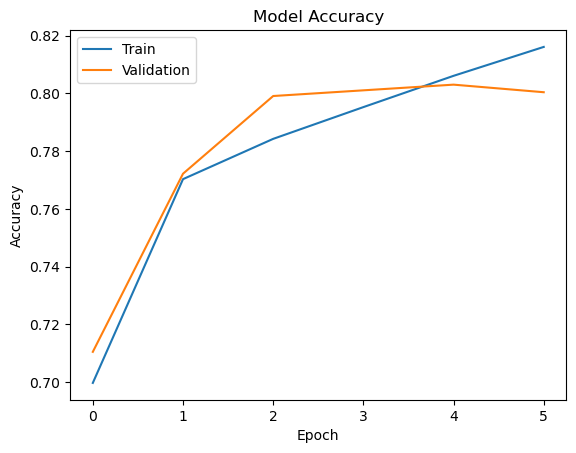

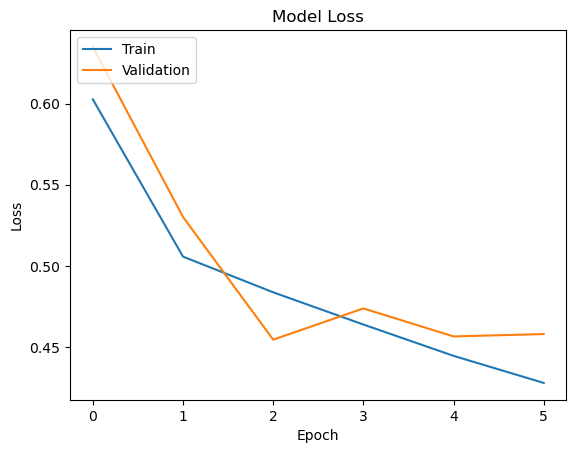

In [41]:
# Evaluate the model
loss, accuracy = model_rnn_glove.evaluate(val_padded, y_val)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Plot accuracy and loss
for metric, title in zip(['accuracy', 'loss'], ['Model Accuracy', 'Model Loss']):
    plt.plot(history_rnn_glove.history[metric], label='Train')
    plt.plot(history_rnn_glove.history[f'val_{metric}'], label='Validation')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend(loc='upper left')
    plt.show()

In [43]:
# Define CNN model with GloVe embeddings
model_cnn_glove = Sequential([
    Embedding(num_unique_words, output_dim=300, input_length=max_length, weights=[embedding_matrix], trainable=False),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2),
    BatchNormalization(),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_cnn_glove.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │       6,627,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,627,900 (25.28 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 6,627,900 (25.28 MB)

In [44]:
# Compile
opt = Adam(learning_rate=0.0001)
model_cnn_glove.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history_cnn_glove = model_cnn_glove.fit(train_padded, y_train, epochs=10, batch_size=64, validation_data=(val_padded, y_val), callbacks=[early_stopping])

# Evaluate the model
loss_cnn_glove, accuracy_cnn_glove = model_cnn_glove.evaluate(val_padded, y_val)
print('Loss:', loss_cnn_glove)
print('Accuracy:', accuracy_cnn_glove)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.5563 - loss: 0.8667 - val_accuracy: 0.6507 - val_loss: 0.6227
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7036 - loss: 0.5956 - val_accuracy: 0.7249 - val_loss: 0.5517
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7560 - loss: 0.5216 - val_accuracy: 0.7630 - val_loss: 0.5131
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7904 - loss: 0.4654 - val_accuracy: 0.7669 - val_loss: 0.4942
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8174 - loss: 0.4181 - val_accuracy: 0.7781 - val_loss: 0.4891
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8242 - loss: 0.4114 - val_accuracy: 0.7761 - val_loss: 0.4858
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8403 - loss: 0.3711 - val_accuracy: 0.7807 - val_loss: 0.4851
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8523 - loss: 0.3454 - val_accuracy: 0.7873 - v

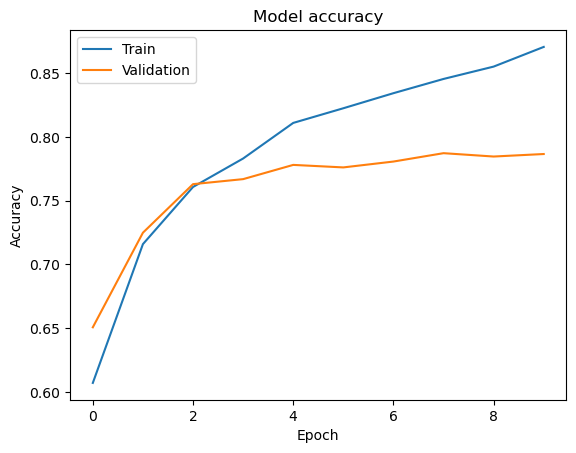

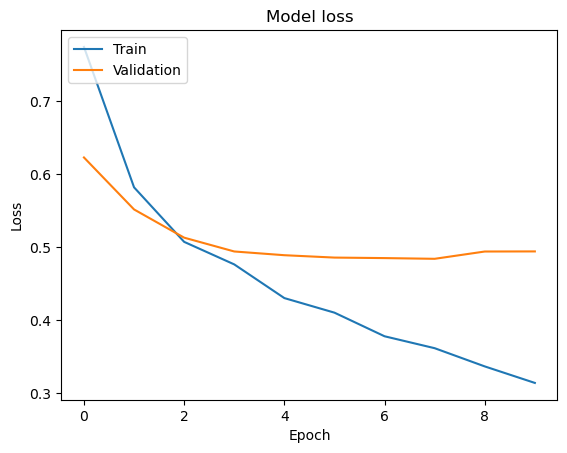

In [45]:
# Plot the training and validation accuracy
plt.plot(history_cnn_glove.history['accuracy'])
plt.plot(history_cnn_glove.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history_cnn_glove.history['loss'])
plt.plot(history_cnn_glove.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

<h3> Comparision with XGBoost</h3>
We also evaluated the classification accuracy using an algorithm that uses TF-IDF vectorization and XGBoost.
Without tuning hyperparameters, there was not much difference from the deep learning method.

In [47]:
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

# TF-IDF vectorization
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

# Train XGBoost model
xgb_model = XGBClassifier()
xgb_model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = xgb_model.predict(X_val_tfidf)

# Evaluate accuracy
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.91      0.83       886
           1       0.83      0.59      0.69       637

    accuracy                           0.78      1523
   macro avg       0.80      0.75      0.76      1523
weighted avg       0.79      0.78      0.77      1523



In [49]:
# TF-IDF vectorization for test_df
test_df['text'] = test_df.text.map(remove_URL)
test_df['text'] = test_df.text.map(punc_remove)
test_df['text'] = test_df['text'].map(remove_stopwords)

X_test_tfidf = vectorizer.transform(test_df.text)

# Make predictions on test_df
y_test_pred = xgb_model.predict(X_test_tfidf)

# Create submission DataFrame
submission_df = pd.DataFrame({'id': test_df.id, 'target': y_test_pred})

# Save submission to CSV
submission_df.to_csv('submission_xgb.csv', index=False)

<h3> Conclusion</h3>
I compared three models: LSTM, CNN, and XGBoost, with the RNN model using GloVe achieving the highest score.

I experimented with various hyperparameters, such as Dropout for the RNN and CNN models, but reaching a final score above 0.8 proved challenging. XGBoost yielded similar results. However, incorporating GloVe, a pre-trained word embedding, improved the models' stability. GloVe embeddings, derived from large and diverse text corpora, encode rich semantic information, making them particularly beneficial for tasks with limited training data.

While the performance was decent, there remains potential for improvement. Observing other participants in the Kaggle competition, models with higher accuracy often leveraged advanced pre-trained models like BERT (Bidirectional Encoder Representations from Transformers).

In [50]:
# Preprocess the test data
test_df['text'] = test_df.text.map(remove_URL)
test_df['text'] = test_df.text.map(punc_remove)
test_df['text'] = test_df['text'].map(remove_stopwords)

# Convert test data to sequences using the same tokenizer
test_sequences = tokenizer.texts_to_sequences(test_df.text)

# Pad the sequences to have the same length as the training data
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding="post", truncating="post")

# Predict labels for the test data
predictions = model_rnn_glove.predict(test_padded)

# Convert probabilities to class labels (0 or 1)
predicted_labels = (predictions > 0.5).astype(int)

# Add the predicted labels to the test dataframe
test_df['predicted_label'] = predicted_labels

print(test_df.head())

102/102 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step
   id keyword location                                               text  \
0   0     NaN      NaN                   Just happened terrible car crash   
1   2     NaN      NaN  Heard earthquake different cities stay safe ev...   
2   3     NaN      NaN  forest fire spot pond geese fleeing across str...   
3   9     NaN      NaN              Apocalypse lighting Spokane wildfires   
4  11     NaN      NaN             Typhoon Soudelor kills 28 China Taiwan   

   predicted_label  
0                1  
1                1  
2                1  
3                1  
4                1  


In [51]:
submission = pd.DataFrame({
    'id':test_df.id,
    'target':test_df.predicted_label
})

submission.to_csv('submission_rnn_glove.csv', index=False)